In [261]:
## Ran for eveything now with excluding the gauges that we don't want

# Create a set of dimensionless profiles
Read in all of the events, for all durations, for all gauges, for all ensemble members.  
Convert them to dimensionless profiles, with 12 values between 0 and 1.  
Each value is a dimensionless, cumulative rainfall value (cumulative rainfall at this timestep, normalised by the total event rainfall):
- 0 means no rainfall has occurred, and 
- 1 means the total event rainfall has been reached.  

If there are less than 12 values, then these are filled in with interpolation

In [262]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import pandas as pd
import re
from datetime import datetime

from Create_Profiles_Functions import *

quintile_mapping = {1: 'F2', 2: 'F1', 3: 'C', 4: 'B1', 5: 'B2'}

In [263]:
gauge_nums = range(0,1294)

# NIMROD - 30 mins
### Make profiles

In [264]:
def interpolate_rainfall(rainfall, bin_number):
    if rainfall is None or len(rainfall) < 2:
        return None

    # Define target points for bin_number bins
    target_points = np.linspace(0, 1, bin_number+1)
    
    # Create interpolation function based on existing data points
    rainfall_times = np.array(range(0, len(rainfall)))

    # Normalize time from 0 to 1
    normalized_time = (rainfall_times - rainfall_times[0]) / (rainfall_times[-1] - rainfall_times[0])
    interpolation_func = interp1d(normalized_time, rainfall, kind='linear', fill_value="extrapolate")
    
    # Interpolate values at target points
    interpolated_values = interpolation_func(target_points)
    
    return interpolated_values, target_points

def create_cumulative_event(rainfall, interval=0.5):
    if rainfall is None:
        return None, None
    
    # Calculate cumulative rainfall
    cumulative_rainfall = np.cumsum(rainfall)
    cumulative_rainfall = [0] + cumulative_rainfall
    
    # Generate corresponding time points
    time_points = np.arange(0, len(rainfall) + 1) * interval
    
    return  [0] + cumulative_rainfall.tolist(), time_points.tolist()

def create_normalised_event(rainfall):
    # Check if the input array is None or empty
    if rainfall is None or len(rainfall) == 0:
        # print("Input array is None or empty. Cannot normalize.")
        return None

    # Check if the maximum value is zero to avoid division by zero
    if np.max(rainfall) == 0:
        print("Maximum rainfall is zero. Cannot normalize.")
        return rainfall  # Return the input as-is, or handle appropriately

    # Normalize rainfall by dividing each value by the maximum value
    normalized_rainfall = rainfall / np.max(rainfall)
    normalized_rainfall = normalized_rainfall.to_list()
    
    rainfall_times = np.arange(0, len(rainfall) * 0.5, 0.5)
    
    # Debug prints to check the input and output
    return normalized_rainfall, rainfall_times

def create_normalised_event_old(cumulative_rainfall):
    """
    Create a dimensionless rainfall profile by normalizing the cumulative rainfall 
    and time arrays.
    
    Parameters:
        rainfall_times (np.array): Array of time measurements in any consistent unit.
        rainfall_amounts (np.array): Array of corresponding rainfall amounts.
        
    Returns:
        tuple: Two numpy arrays representing the normalized time and cumulative rainfall.
    """
    cumulative_rainfall=np.array(cumulative_rainfall)
    rainfall_times = np.arange(0, len(cumulative_rainfall) * 0.5, 0.5)
    
    # Normalize time from 0 to 1
    normalized_time = (rainfall_times - rainfall_times[0]) / (rainfall_times[-1] - rainfall_times[0])
    
    # Normalize cumulative rainfall from 0 to 1
    normalized_rainfall = cumulative_rainfall / cumulative_rainfall[-1]
    
    return normalized_time, normalized_rainfall

def create_dimensionless_event(cumulative_rainfall, cumulative_rainfall_times):

    # Step 3: Normalize the cumulative rainfall by the total event depth
    total_event_depth = cumulative_rainfall[-1]
    normalized_cumulative_rainfall = np.array(cumulative_rainfall) / total_event_depth

#     # Step 4: Calculate the cumulative event duration
#     # Since each time step is 30 minutes, we multiply the index by 0.5 (for hours)
#     time_step = 0.5  # 30 minutes = 0.5 hours
#     cumulative_duration = np.arange(1, len(cumulative_rainfall) + 1) * time_step
    
#     # Step 5: Normalize the cumulative duration by the total event duration
#     total_event_duration = cumulative_duration[-1]
#     normalized_cumulative_duration = cumulative_duration / total_event_duration

    total_event_time = cumulative_rainfall_times[-1]
    normalized_cumulative_rainfall_times = np.array(cumulative_rainfall_times) / total_event_time
    normalized_cumulative_rainfall_times
    
    return normalized_cumulative_rainfall, normalized_cumulative_rainfall_times

In [268]:
# gauge_num=0
# fp = '/nfs/a161/gy17m2a/PhD/ProcessedData/IndependentEvents/NIMROD_30mins/NIMROD_2.2km_filtered_100/1292/WholeYear/6hrs_2020_v2_part0.csv'
# this_event = read_event(gauge_num, fp)
# trimmed_event = remove_leading_and_trailing_zeroes(this_event)
# real_trimmed_event, problem_events = remove_events_with_problems(trimmed_event, verbose=False)

# precip = real_trimmed_event['precipitation (mm)']
# cumulative_rainfall, cumulative_rainfall_times = create_cumulative_event(precip)
# dimensionless_cumulative_rainfall, dimensionless_time =  create_dimensionless_event(cumulative_rainfall)

# interpolated15_cumulative_rainfall, inter_time_15 = interpolate_rainfall(dimensionless_cumulative_rainfall,15)
# interpolated12_cumulative_rainfall, inter_time_12 = interpolate_rainfall(dimensionless_cumulative_rainfall,12)

# interpolated15_incremental_rainfall = create_incremental_event(interpolated15_cumulative_rainfall)
# interpolated12_incremental_rainfall = create_incremental_event(interpolated12_cumulative_rainfall)

In [279]:
def create_dataframe_row(gauge_num, this_event):
   
    trimmed_event = remove_leading_and_trailing_zeroes(this_event)
    real_trimmed_event, problem_events = remove_events_with_problems(trimmed_event, verbose=False)
    season = get_season(trimmed_event['times'][0])
    
    if real_trimmed_event is None:
        precip = None
    else:
        precip = real_trimmed_event['precipitation (mm)']

        cumulative_rainfall, cumulative_rainfall_times = create_cumulative_event(precip)
        dimensionless_cumulative_rainfall, dimensionless_times =  create_dimensionless_event(cumulative_rainfall, cumulative_rainfall_times)
        interpolated15_cumulative_rainfall, interpolated15_times = interpolate_rainfall(dimensionless_cumulative_rainfall,15)
        interpolated12_cumulative_rainfall, interpolated12_times = interpolate_rainfall(dimensionless_cumulative_rainfall,12)
        interpolated15_incremental_rainfall = create_incremental_event(interpolated15_cumulative_rainfall)
        interpolated12_incremental_rainfall = create_incremental_event(interpolated12_cumulative_rainfall)
    
    row_data = {
        'gauge_num': gauge_num,
        'season': season,
        'precip': precip.values if precip is not None else None,
        'Volume': sum(precip) if precip is not None else None,
        'Year': extract_year(trimmed_event),
        'times': trimmed_event['times'].values if trimmed_event is not None else None,
        'duration': len(real_trimmed_event) / 2 if precip is not None else None,
        'cumulative_rainfall': cumulative_rainfall if real_trimmed_event is not None else None,
        'cumulative_rainfall_times': cumulative_rainfall_times if real_trimmed_event is not None else None,
        'dimensionless_cumulative_rainfall': dimensionless_cumulative_rainfall if real_trimmed_event is not None else None,
        'dimensionless_cumulative_rainfall_times': dimensionless_times if real_trimmed_event is not None else None,
        'interpolated15_cumulative_rainfall': interpolated15_cumulative_rainfall if real_trimmed_event is not None else None,
        'interpolated12_cumulative_rainfall': interpolated12_cumulative_rainfall if real_trimmed_event is not None else None,
        'interpolated15_times': interpolated15_times if real_trimmed_event is not None else None,
        'interpolated12_times': interpolated12_times if real_trimmed_event is not None else None,       
        'interpolated15_incremental_rainfall': interpolated15_incremental_rainfall if real_trimmed_event is not None else None,
        'interpolated12_incremental_rainfall': interpolated12_incremental_rainfall if real_trimmed_event is not None else None,
    }

    return row_data

# Initialize an empty list to collect rows
rows = []

for nimrod_option in ["NIMROD_2.2km_filtered_100"]:
    for gauge_num in range(0, 1294):
        if gauge_num not in [444, 827, 888]:
            print(f"Processing gauge {gauge_num}")
            files = [f for f in os.listdir(f"/nfs/a161/gy17m2a/PhD/ProcessedData/IndependentEvents/NIMROD_30mins/{nimrod_option}/{gauge_num}/WholeYear") if f.endswith('.csv')]
            files = np.sort(files)

            for file in files:
                fp = f"/nfs/a161/gy17m2a/PhD/ProcessedData/IndependentEvents/NIMROD_30mins/{nimrod_option}/{gauge_num}/WholeYear/{file}"
                if '2080' in fp:
                    continue

                this_event = read_event(gauge_num, fp)

                # Create the row data
                row_data = create_dataframe_row(gauge_num,this_event)
                rows.append(row_data)

# Create DataFrame from collected rows
df = pd.DataFrame(rows)

# Add duration categories
df = add_duration_cats_based_on_data(df)
df = add_duration_cats_predetermined(df)

Save the DataFrame
with open(f"/nfs/a319/gy17m2a/PhD/ProcessedData/Profiles/NIMROD_30mins/WholeYear/{nimrod_option}_profiles_df.pkl", 'wb') as file:
    pickle.dump(df, file)


Processing gauge 0
Processing gauge 1
Processing gauge 2
Processing gauge 3
Processing gauge 4
Processing gauge 5
Processing gauge 6
Processing gauge 7
Processing gauge 8
Processing gauge 9
Processing gauge 10
Processing gauge 11
Processing gauge 12
Processing gauge 13
Processing gauge 14
Processing gauge 15
Processing gauge 16
Processing gauge 17
Processing gauge 18
Processing gauge 19
Processing gauge 20
Processing gauge 21
Processing gauge 22
Processing gauge 23
Processing gauge 24
Processing gauge 25
Processing gauge 26
Processing gauge 27
Processing gauge 28
Processing gauge 29
Processing gauge 30
Processing gauge 31
Processing gauge 32
Processing gauge 33
Processing gauge 34
Processing gauge 35
Processing gauge 36
Processing gauge 37
Processing gauge 38
Processing gauge 39
Processing gauge 40
Processing gauge 41
Processing gauge 42
Processing gauge 43
Processing gauge 44
Processing gauge 45
Processing gauge 46
Processing gauge 47
Processing gauge 48
Processing gauge 49
Processing

Processing gauge 396
Processing gauge 397
Processing gauge 398
Processing gauge 399
Processing gauge 400
Processing gauge 401
Processing gauge 402
Processing gauge 403
Processing gauge 404
Processing gauge 405
Processing gauge 406
Processing gauge 407
Processing gauge 408
Processing gauge 409
Processing gauge 410
Processing gauge 411
Processing gauge 412
Processing gauge 413
Processing gauge 414
Processing gauge 415
Processing gauge 416
Processing gauge 417
Processing gauge 418
Processing gauge 419
Processing gauge 420
Processing gauge 421
Processing gauge 422
Processing gauge 423
Processing gauge 424
Processing gauge 425
Processing gauge 426
Processing gauge 427
Processing gauge 428
Processing gauge 429
Processing gauge 430
Processing gauge 431
Processing gauge 432
Processing gauge 433
Processing gauge 434
Processing gauge 435
Processing gauge 436
Processing gauge 437
Processing gauge 438
Processing gauge 439
Processing gauge 440
Processing gauge 441
Processing gauge 442
Processing ga

Processing gauge 788
Processing gauge 789
Processing gauge 790
Processing gauge 791
Processing gauge 792
Processing gauge 793
Processing gauge 794
Processing gauge 795
Processing gauge 796
Processing gauge 797
Processing gauge 798
Processing gauge 799
Processing gauge 800
Processing gauge 801
Processing gauge 802
Processing gauge 803
Processing gauge 804
Processing gauge 805
Processing gauge 806
Processing gauge 807
Processing gauge 808
Processing gauge 809
Processing gauge 810
Processing gauge 811
Processing gauge 812
Processing gauge 813
Processing gauge 814
Processing gauge 815
Processing gauge 816
Processing gauge 817
Processing gauge 818
Processing gauge 819
Processing gauge 820
Processing gauge 821
Processing gauge 822
Processing gauge 823
Processing gauge 824
Processing gauge 825
Processing gauge 826
Processing gauge 828
Processing gauge 829
Processing gauge 830
Processing gauge 831
Processing gauge 832
Processing gauge 833
Processing gauge 834
Processing gauge 835
Processing ga

Processing gauge 1172
Processing gauge 1173
Processing gauge 1174
Processing gauge 1175
Processing gauge 1176
Processing gauge 1177
Processing gauge 1178
Processing gauge 1179
Processing gauge 1180
Processing gauge 1181
Processing gauge 1182
Processing gauge 1183
Processing gauge 1184
Processing gauge 1185
Processing gauge 1186
Processing gauge 1187
Processing gauge 1188
Processing gauge 1189
Processing gauge 1190
Processing gauge 1191
Processing gauge 1192
Processing gauge 1193
Processing gauge 1194
Processing gauge 1195
Processing gauge 1196
Processing gauge 1197
Processing gauge 1198
Processing gauge 1199
Processing gauge 1200
Processing gauge 1201
Processing gauge 1202
Processing gauge 1203
Processing gauge 1204
Processing gauge 1205
Processing gauge 1206
Processing gauge 1207
Processing gauge 1208
Processing gauge 1209
Processing gauge 1210
Processing gauge 1211
Processing gauge 1212
Processing gauge 1213
Processing gauge 1214
Processing gauge 1215
Processing gauge 1216
Processing

In [281]:
# Save the DataFrame
with open(f"/nfs/a319/gy17m2a/PhD/ProcessedData/Profiles/NIMROD_30mins/WholeYear/{nimrod_option}_profiles_df_NEW.pkl", 'wb') as file:
    pickle.dump(df, file)

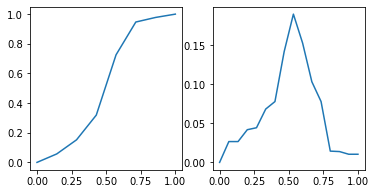

In [277]:
fig,axs=plt.subplots(ncols=2,figsize=(6,3))
axs[0].plot(df['dimensionless_cumulative_rainfall_times'][100], df['dimensionless_cumulative_rainfall'][100])
axs[1].plot(df['interpolated15_times'][100], df['interpolated15_incremental_rainfall'][100])

In [266]:
# def length_dimensionless_profile(time):
#     if time is None:
#         return None
#     else:
#         return len(time)
    
# df['len_dimensionless_profile']   = df['dimensionless_time'].apply(length_dimensionless_profile)
# plt.hist(df['len_dimensionless_profile'] )

# NIMROD 5 mins

In [ ]:
# Initialize an empty DataFrame with the desired columns
# columns = [
#     'gauge_num',  'season', 'precip', 'Volume','Year', 'times', 'duration',
#     'normalized_rainfall', 'cumulative_normalized_rainfall', 'cumulative_rainfall',
#     'interpolated15_cumulative_rainfall', 'interpolated12_cumulative_rainfall','interpolated15_incremental_rainfall','interpolated12_incremental_rainfall',
#     'interpolated15_cumulative_normalized_rainfall','interpolated12_cumulative_normalized_rainfall','interpolated15_incremental_normalized_rainfall','interpolated12_incremental_normalized_rainfall',
#     'max_quintile_raw_rain','max_quintile_profile_12', 'max_quintile_profile_15', 'max_quintile_normalised_rain', 'max_quintile_profile_12_norm', "max_quintile_profile_15_norm"]
# df = pd.DataFrame(columns=columns)

for nimrod_option in ["NIMROD_1km_filtered_100"]:
    for gauge_num in range(866,1201):
        if gauge_num not in [444, 827, 888]:
            print(f"gauge {gauge_num}")
            files = [f for f in os.listdir(f"/nfs/a161/gy17m2a/PhD/ProcessedData/IndependentEvents/NIMROD_5mins/{nimrod_option}/{gauge_num}/WholeYear") if f.endswith('.csv')]
            files = np.sort(files)

            for file in files:
                fp = f"/nfs/a161/gy17m2a/PhD/ProcessedData/IndependentEvents/NIMROD_5mins/{nimrod_option}/{gauge_num}/WholeYear/{file}"
                if '2080' in fp:
                    continue

                this_event = read_event(gauge_num, fp)
                trimmed_event = remove_leading_and_trailing_zeroes(this_event)
                real_trimmed_event, problem_events = remove_events_with_problems(trimmed_event, verbose=False)

                if real_trimmed_event is not None:
                    
                    precip = real_trimmed_event['precipitation (mm/hr)']
                    normalized_rainfall = create_normalised_event(real_trimmed_event['precipitation (mm/hr)'])
                    cumulative_normalized_rainfall = create_cumulative_event(normalized_rainfall)
                    cumulative_rainfall = create_cumulative_event(precip)
                    
                    interpolated15_cumulative_rainfall = interpolate_rainfall(cumulative_rainfall,15)
                    interpolated12_cumulative_rainfall = interpolate_rainfall(cumulative_rainfall,12)
                    interpolated15_incremental_rainfall = create_incremental_event(interpolated15_cumulative_rainfall)
                    interpolated12_incremental_rainfall = create_incremental_event(interpolated12_cumulative_rainfall)
                    
                    interpolated15_cumulative_normalized_rainfall = interpolate_rainfall(cumulative_normalized_rainfall,15)
                    interpolated12_cumulative_normalized_rainfall = interpolate_rainfall(cumulative_normalized_rainfall,12)
                    interpolated15_incremental_normalized_rainfall = create_incremental_event(interpolated15_cumulative_normalized_rainfall)
                    interpolated12_incremental_normalized_rainfall = create_incremental_event(interpolated12_cumulative_normalized_rainfall)
                    
                    max_quintile_raw_rain = find_part_with_most_rain(precip, 5)
                    max_quintile_profile_12 = find_part_with_most_rain(interpolated12_incremental_rainfall, 5)
                    max_quintile_profile_15 = find_part_with_most_rain(interpolated15_incremental_rainfall, 5)
                    
                    max_quintile_normalised_rain = find_part_with_most_rain(normalized_rainfall, 5)
                    max_quintile_profile_12_norm = find_part_with_most_rain(interpolated12_incremental_normalized_rainfall, 5)
                    max_quintile_profile_15_norm = find_part_with_most_rain(interpolated15_incremental_normalized_rainfall, 5)
                    
                    duration = len(real_trimmed_event) / 2
                    times = trimmed_event['times'].values
                    season = get_season(trimmed_event['times'][0])
                    year=extract_year(trimmed_event)
                    
                else:
                    precip=trimmed_event['precipitation (mm/hr)']
                    normalized_rainfall = None
                    cumulative_normalized_rainfall = None
                    cumulative_rainfall = None
                    
                    interpolated15_cumulative_rainfall = None
                    interpolated12_cumulative_rainfall = None
                    interpolated15_incremental_rainfall = None
                    interpolated12_incremental_rainfall = None
                    
                    interpolated15_cumulative_normalized_rainfall = None
                    interpolated12_cumulative_normalized_rainfall = None
                    interpolated15_incremental_normalized_rainfall = None
                    interpolated12_incremental_normalized_rainfall = None
                    
                    max_quintile_raw_rain = None
                    max_quintile_profile_12 = None
                    max_quintile_profile_15 = None
                    
                    max_quintile_normalised_rain = None
                    max_quintile_profile_12_norm = None
                    max_quintile_profile_15_norm = None
                    
                    duration = None
                    season = None
                    year=None
                    times=None
                    
                # Append the row to the DataFrame
                df = df.append({
                    'gauge_num': gauge_num,
                    'season': season,
                    'precip': precip.values,
                    
                    'Volume': sum(precip),
                    'Year':year,
                    'times':times, 
                    'duration': duration,
                    
                    'normalized_rainfall':normalized_rainfall,
                    'cumulative_normalized_rainfall':cumulative_normalized_rainfall,
                    'cumulative_rainfall':cumulative_rainfall,
                    
                    'interpolated15_cumulative_rainfall':interpolated15_cumulative_rainfall,
                    'interpolated12_cumulative_rainfall':interpolated12_cumulative_rainfall,                    
                    'interpolated15_incremental_rainfall':interpolated15_incremental_rainfall,
                    'interpolated12_incremental_rainfall': interpolated12_incremental_rainfall,
                    
                    'interpolated15_cumulative_normalized_rainfall':interpolated15_cumulative_normalized_rainfall,
                    "interpolated12_cumulative_normalized_rainfall":interpolated12_cumulative_normalized_rainfall,
                    'interpolated15_incremental_normalized_rainfall':interpolated15_incremental_normalized_rainfall,
                    'interpolated12_incremental_normalized_rainfall':interpolated12_incremental_normalized_rainfall,
                    
                    'max_quintile_raw_rain': max_quintile_raw_rain,
                    'max_quintile_profile_12': max_quintile_profile_12,
                    'max_quintile_profile_15': max_quintile_profile_15,
                    'max_quintile_normalised_rain': max_quintile_normalised_rain,
                    'max_quintile_profile_12_norm': max_quintile_profile_12_norm,
                    'max_quintile_profile_15_norm': max_quintile_profile_15_norm                    
                }, ignore_index=True)
                

df['Loading_profile_raw_rain'] = df['max_quintile_raw_rain'].map(quintile_mapping)
df['Loading_profile12'] = df['max_quintile_profile_12'].map(quintile_mapping)
df['Loading_profile15'] = df['max_quintile_profile_15'].map(quintile_mapping)
df['Loading_profile_normalised_rain'] = df['max_quintile_normalised_rain'].map(quintile_mapping)
df['Loading_profile_norm_12'] = df['max_quintile_profile_12_norm'].map(quintile_mapping)
df['Loading_profile_norm_15'] = df['max_quintile_profile_15_norm'].map(quintile_mapping)

df = add_duration_cats_based_on_data(df)
df = add_duration_cats_predetermined(df)

with open(f"/nfs/a319/gy17m2a/PhD/ProcessedData/Profiles/NIMROD_5mins/WholeYear/{nimrod_option}_profiles_df.pkl", 'wb') as file:
    pickle.dump(df, file)

In [ ]:
df["DurationRange_notpersonalised"]

# UKCP18
### Make and pickle profiles

In [ ]:
# # Initialize an empty DataFrame with the desired columns
# Initialize an empty DataFrame with the desired columns
columns = [
    'gauge_num',  'season', 'precip', 'Volume','Year', 'times', 'duration',
    'normalized_rainfall', 'cumulative_normalized_rainfall', 'cumulative_rainfall',
    'interpolated15_cumulative_rainfall', 'interpolated12_cumulative_rainfall','interpolated15_incremental_rainfall','interpolated12_incremental_rainfall',
    'interpolated15_cumulative_normalized_rainfall','interpolated12_cumulative_normalized_rainfall','interpolated15_incremental_normalized_rainfall','interpolated12_incremental_normalized_rainfall',
    'max_quintile_raw_rain','max_quintile_profile_12', 'max_quintile_profile_15', 'max_quintile_normalised_rain', 'max_quintile_profile_12_norm', "max_quintile_profile_15_norm"]
df2 = pd.DataFrame(columns=columns)

for em in ["bb198"]:
    for gauge_num in range(0, 1293):
        if gauge_num not in [444, 827, 888]:
            print(f"gauge {gauge_num}")
            files = [f for f in os.listdir(f"/nfs/a161/gy17m2a/PhD/ProcessedData/IndependentEvents/UKCP18_30mins/{em}/{gauge_num}/WholeYear/") if f.endswith('.csv')]
            files = np.sort(files)

            for file in files:
                fp = f"/nfs/a161/gy17m2a/PhD/ProcessedData/IndependentEvents/UKCP18_30mins/{em}/{gauge_num}/WholeYear/{file}"
                if '2080' in fp:
                    continue

                this_event = read_event(gauge_num, fp)
                trimmed_event = remove_leading_and_trailing_zeroes(this_event)
                real_trimmed_event, problem_events = remove_events_with_problems(trimmed_event, verbose=False)

                if real_trimmed_event is not None:
                    
                    precip = real_trimmed_event['precipitation (mm/hr)']
                    normalized_rainfall = create_normalised_event(real_trimmed_event['precipitation (mm/hr)'])
                    cumulative_normalized_rainfall = create_cumulative_event(normalized_rainfall)
                    cumulative_rainfall = create_cumulative_event(precip)
                    
                    interpolated15_cumulative_rainfall = interpolate_rainfall(cumulative_rainfall,15)
                    interpolated12_cumulative_rainfall = interpolate_rainfall(cumulative_rainfall,12)
                    interpolated15_incremental_rainfall = create_incremental_event(interpolated15_cumulative_rainfall)
                    interpolated12_incremental_rainfall = create_incremental_event(interpolated12_cumulative_rainfall)
                    
                    interpolated15_cumulative_normalized_rainfall = interpolate_rainfall(cumulative_normalized_rainfall,15)
                    interpolated12_cumulative_normalized_rainfall = interpolate_rainfall(cumulative_normalized_rainfall,12)
                    interpolated15_incremental_normalized_rainfall = create_incremental_event(interpolated15_cumulative_normalized_rainfall)
                    interpolated12_incremental_normalized_rainfall = create_incremental_event(interpolated12_cumulative_normalized_rainfall)
                    
                    max_quintile_raw_rain = find_part_with_most_rain(precip, 5)
                    max_quintile_profile_12 = find_part_with_most_rain(interpolated12_incremental_rainfall, 5)
                    max_quintile_profile_15 = find_part_with_most_rain(interpolated15_incremental_rainfall, 5)
                    
                    max_quintile_normalised_rain = find_part_with_most_rain(normalized_rainfall, 5)
                    max_quintile_profile_12_norm = find_part_with_most_rain(interpolated12_incremental_normalized_rainfall, 5)
                    max_quintile_profile_15_norm = find_part_with_most_rain(interpolated15_incremental_normalized_rainfall, 5)
                    
                    duration = len(real_trimmed_event) / 2
                    times = trimmed_event['times'].values
                    season = get_season(trimmed_event['times'][0])
                    year=extract_year(trimmed_event)
                    
                else:
                    precip=trimmed_event['precipitation (mm/hr)']
                    normalized_rainfall = None
                    cumulative_normalized_rainfall = None
                    cumulative_rainfall = None
                    
                    interpolated15_cumulative_rainfall = None
                    interpolated12_cumulative_rainfall = None
                    interpolated15_incremental_rainfall = None
                    interpolated12_incremental_rainfall = None
                    
                    interpolated15_cumulative_normalized_rainfall = None
                    interpolated12_cumulative_normalized_rainfall = None
                    interpolated15_incremental_normalized_rainfall = None
                    interpolated12_incremental_normalized_rainfall = None
                    
                    max_quintile_raw_rain = None
                    max_quintile_profile_12 = None
                    max_quintile_profile_15 = None
                    
                    max_quintile_normalised_rain = None
                    max_quintile_profile_12_norm = None
                    max_quintile_profile_15_norm = None
                    
                    duration = None
                    season = None
                    year=None
                    times=None
                    
                # Append the row to the DataFrame
                df2 = df2.append({
                    'gauge_num': gauge_num,
                    'season': season,
                    'precip': precip.values,
                    
                    'Volume': sum(precip),
                    'Year':year,
                    'times':times, 
                    'duration': duration,
                    
                    'normalized_rainfall':normalized_rainfall,
                    'cumulative_normalized_rainfall':cumulative_normalized_rainfall,
                    'cumulative_rainfall':cumulative_rainfall,
                    
                    'interpolated15_cumulative_rainfall':interpolated15_cumulative_rainfall,
                    'interpolated12_cumulative_rainfall':interpolated12_cumulative_rainfall,                    
                    'interpolated15_incremental_rainfall':interpolated15_incremental_rainfall,
                    'interpolated12_incremental_rainfall': interpolated12_incremental_rainfall,
                    
                    'interpolated15_cumulative_normalized_rainfall':interpolated15_cumulative_normalized_rainfall,
                    "interpolated12_cumulative_normalized_rainfall":interpolated12_cumulative_normalized_rainfall,
                    'interpolated15_incremental_normalized_rainfall':interpolated15_incremental_normalized_rainfall,
                    'interpolated12_incremental_normalized_rainfall':interpolated12_incremental_normalized_rainfall,
                    
                    'max_quintile_raw_rain': max_quintile_raw_rain,
                    'max_quintile_profile_12': max_quintile_profile_12,
                    'max_quintile_profile_15': max_quintile_profile_15,
                    'max_quintile_normalised_rain': max_quintile_normalised_rain,
                    'max_quintile_profile_12_norm': max_quintile_profile_12_norm,
                    'max_quintile_profile_15_norm': max_quintile_profile_15_norm                    
                }, ignore_index=True)
                

df2['Loading_profile_raw_rain'] = df2['max_quintile_raw_rain'].map(quintile_mapping)
df2['Loading_profile12'] = df2['max_quintile_profile_12'].map(quintile_mapping)
df2['Loading_profile15'] = df2['max_quintile_profile_15'].map(quintile_mapping)
df2['Loading_profile_normalised_rain'] = df2['max_quintile_normalised_rain'].map(quintile_mapping)
df2['Loading_profile_norm_12'] = df2['max_quintile_profile_12_norm'].map(quintile_mapping)
df2['Loading_profile_norm_15'] = df2['max_quintile_profile_15_norm'].map(quintile_mapping)

df2 = add_duration_cats_based_on_data(df2)
df2 = add_duration_cats_predetermined(df2)

with open(f"/nfs/a319/gy17m2a/PhD/ProcessedData/Profiles/UKCP18_30mins/{em}/profiles_df.pkl", 'wb') as file:
    pickle.dump(df2, file)